In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from MFEA_lib.GA import population_init, factorial_cost, factorial_rank, skill_factor_best_task
from MFEA_lib.model.mfea import MFEA_base, AbstractModel
from MFEA_lib.tasks.function import AbstractFunc
from MFEA_lib.operators import CrossOver, Mutation, Selection
from MFEA_lib.operators.CrossOver import SBX_CrossOver
from MFEA_lib.operators.Selection import ElitismSelection
from MFEA_lib.operators.Mutation import Polynomial_Mutation
from MFEA_lib.tasks.Benchmark import CEC17_benchmark, GECCO20_benchmark_50tasks

#### Build model

In [2]:
class SA_MFEA(AbstractModel):
    def success_history_memory_update(self, memory_M:np.ndarray, next_pos: np.ndarray, S: list, delta: list):
        for i in range(len(self.tasks)):
            for j in range(i+ 1, len(self.tasks)):
                if len(S[i][j]) != 0:
                    memory_M[i, j][next_pos[i][j]] =\
                        np.sum(np.array(delta[i][j]) * np.array(S[i][j])**2)/np.sum(np.array(delta[i][j]) * (np.array(S[i][j]))+ 1e-10)

                    next_pos[i, j] = (next_pos[i, j] + 1) % memory_M.shape[2]
        return memory_M, next_pos

    def compile(self, cross_over = CrossOver.SBX_CrossOver(), mutation=  Mutation.Polynomial_Mutation(), selection= Selection.ElitismSelection()):
        super().compile(cross_over, mutation, selection)
    
    def fit(self, tasks: list[AbstractFunc], MAXEVALS, num_inds_each_task=100, nb_inds_min = None, H = 30, sigmoid = 0.1, 
                evaluate_initial_skillFactor=True, range_init_pop= [0, 1]) -> tuple[list[np.ndarray], np.ndarray]:

        if nb_inds_min is not None:
            assert num_inds_each_task > nb_inds_min
        else:
            nb_inds_min = num_inds_each_task
            
        self.tasks = tasks

        # initial history of factorial cost -> for render
        self.history_cost = np.empty((0, len(tasks)), np.float) 

        # dim of Unified search space
        dim_uss = max([t.dim for t in tasks])

        # initial population
        inf, sup = range_init_pop
        population, skill_factor_arr = population_init(
            N = num_inds_each_task,
            num_tasks= len(tasks),
            d = dim_uss,
            min_val= inf,
            max_val= sup
        )

        if evaluate_initial_skillFactor:
            skill_factor_arr = skill_factor_best_task(population, tasks)
        pop_fcost = factorial_cost(population, skill_factor_arr, tasks)

        # SA params:
        eval_k = np.zeros(len(tasks))
        max_Eval = int(MAXEVALS / len(tasks))
        epoch = 0

        # Initial success hitory memory M
        memory_M = np.ones((len(tasks), len(tasks), H))/2
        next_update_pos_M = np.zeros((len(tasks), len(tasks)), np.int)

        # mean and std of rmp each generations
        # len(tasks) * len(tasks) * generations * 2
        self.saved_rmp = np.array([[[[0.5, 0]]]* len(tasks)] * len(tasks)).tolist()

        # save history_cost
        self.history_cost = np.append(self.history_cost, 
            [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
            axis = 0
        )

        while np.sum(eval_k) < MAXEVALS:
            
            S = np.empty((len(tasks), len(tasks), 0)).tolist()
            delta = np.empty((len(tasks), len(tasks), 0)).tolist()

            # initial offspring of generation
            offspring = np.empty((0, dim_uss))
            offspring_skill_factor = np.empty((0, ), np.int)
            offspring_fcost = np.empty((0, ))

            # hisory rmp of this generation
            rmp_this_gen = np.empty((len(tasks), len(tasks), 0)).tolist()

            while len(offspring) < len(population):
                [idx_pa, idx_pb] = np.random.choice(len(population), size= 2, replace= False)
                [pa, pb], [skf_pa, skf_pb] = population[[idx_pa, idx_pb]], skill_factor_arr[[idx_pa, idx_pb]]

                if skf_pa == skf_pb:
                    # Intra-crossover + mutate
                    oa, ob = self.cross_over(pa, pb)
                    oa, ob = self.mutation(oa), self.mutation(ob)
                    skf_oa, skf_ob = skf_pa, skf_pa

                    # Evaluate oa, ob
                    fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)
                    eval_k[skf_oa] += 1
                    eval_k[skf_ob] += 1
                
                else:
                    # swap
                    if skf_pa > skf_pb:
                        pa, pb = pb, pa
                        skf_pa, skf_pb = skf_pb, skf_pa

                    # get rmp
                    mu = np.random.choice(memory_M[skf_pa, skf_pb])
                    rmp = np.random.normal(mu, sigmoid)
                    if rmp < 0: rmp = 0
                    if rmp > 1: rmp = 1

                    # save generation's rmp
                    rmp_this_gen[skf_pa][skf_pb].append(rmp)

                    # Inter-TaskCrossover
                    if np.random.uniform() < rmp:
                        oa, ob = self.cross_over(pa, pb)
                        oa, ob = self.mutation(oa), self.mutation(ob)
                        skf_oa, skf_ob = np.random.choice([skf_pa, skf_pb], size= 2, replace= True)
                    else:
                        # select pa' and pb'
                        idx_pa2 = np.random.choice(np.where(skill_factor_arr == skf_pa)[0])
                        while idx_pa2 == idx_pa:
                            idx_pa2 = np.random.choice(np.where(skill_factor_arr == skf_pa)[0])
                        idx_pb2 = np.random.choice(np.where(skill_factor_arr == skf_pb)[0])
                        while idx_pb2 == idx_pb:
                            idx_pb2 = np.random.choice(np.where(skill_factor_arr == skf_pb)[0])

                        pa2 = population[idx_pa2]
                        pb2 = population[idx_pb2]

                        oa, _ = self.cross_over(pa, pa2)
                        ob, _ = self.cross_over(pb, pb2)

                        skf_oa, skf_ob = skf_pa, skf_pb
                    
                    # Evaluate oa, ob
                    fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)
                    eval_k[skf_oa] += 1
                    eval_k[skf_ob] += 1
                    
                    # Calculate the maximum improvement percetage
                    Delta = 0
                    if skf_oa == skf_pa:
                        Delta = max(Delta, 
                            (pop_fcost[idx_pa] - fcost_oa)/pop_fcost[idx_pa]
                        )
                    else:
                        Delta = max(Delta, 
                            (pop_fcost[idx_pb] - fcost_oa)/pop_fcost[idx_pb]
                        )
                    if skf_ob == skf_pa:
                        Delta = max(Delta, 
                            (pop_fcost[idx_pa] - fcost_ob)/pop_fcost[idx_pa]
                        )
                    else:
                        Delta = max(Delta, 
                            (pop_fcost[idx_pb] - fcost_ob)/pop_fcost[idx_pb]
                        )
                    
                    if Delta > 0:
                        S[skf_pa][skf_pb].append(rmp)
                        delta[skf_pa][skf_pb].append(Delta)
                
                offspring = np.append(offspring, [oa, ob], axis = 0)
                offspring_skill_factor = np.append(offspring_skill_factor, [skf_oa, skf_ob], axis = 0)
                offspring_fcost = np.append(offspring_fcost, [fcost_oa, fcost_ob], axis = 0)

            # update succes history memory 
            memory_M, next_update_pos_M = self.success_history_memory_update(memory_M, next_update_pos_M, S, delta)

            # merge
            population = np.append(population, offspring, axis = 0)
            skill_factor_arr = np.append(skill_factor_arr, offspring_skill_factor, axis = 0)
            pop_fcost = np.append(pop_fcost, offspring_fcost, axis = 0)

            # selection
            pop_fitness = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))
            nb_inds_tasks = min(((nb_inds_min - num_inds_each_task)/max_Eval * eval_k + num_inds_each_task).tolist(), [num_inds_each_task] * len(tasks))
            idx = self.selection(skill_factor_arr, pop_fitness, nb_inds_tasks= nb_inds_tasks)

            population = population[idx]
            skill_factor_arr = skill_factor_arr[idx]
            pop_fcost = pop_fcost[idx]

            #save history
            self.history_cost = np.append(self.history_cost, 
                [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
                axis = 0
            )     

            # save mean and std rmp
            for i in range(len(tasks)):
                for j in range(i + 1, len(tasks)):
                    if len(rmp_this_gen[i][j]) != 0:
                        mu = np.mean(rmp_this_gen[i][j])
                        std = np.std(rmp_this_gen[i][j])
                        self.saved_rmp[i][j].append([mu, std])

            #print
            sys.stdout.write('\r')
            sys.stdout.write('Epoch {}, [%-20s] %3d%% ,pop_size: {}, func_val: {}'
                .format(epoch + 1, len(population),[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))])
                % ('=' * np.int((np.sum(eval_k) + 1) // (MAXEVALS // 20)) + '>' , (np.sum(eval_k) + 1) * 100 // MAXEVALS)
                )
            sys.stdout.flush()

            epoch += 1

        #solve
        sol_idx = [np.argmin(pop_fcost[np.where(skill_factor_arr == idx)]) for idx in range (len(tasks))]
        self.solve = [task.decode(population[np.where(skill_factor_arr == idx)][sol_idx[idx]]) for idx, task in enumerate(tasks)]

        return self.solve, self.history_cost


#### Benchmark

##### CEC17

In [3]:
cec17_10tasks = CEC17_benchmark.get_10tasks_benchmark()

In [4]:
base_model = MFEA_base()
base_model.compile(
    cross_over= SBX_CrossOver(nc = 2),
    mutation= Polynomial_Mutation(nm = 5),
    selection= ElitismSelection()
)
base_sol, base_his = base_model.fit(tasks= cec17_10tasks, num_generations= 1000, num_inds_each_task= 100, rmp =0.3, num_epochs_printed= 10)


np.save(file = "./RESULTS/mfea_base_his_CEC17.npy", arr = base_his )

Epoch [100/1000], [==>                 ]  10% ,func_val: [18397.071899985815, 59578.923316599336, 54664.799074487775, 20.33371467764185, 144809382.23448798, 20.480040874256286, 49.77772427991086, 9613.001630510153, 10.786941891157444, 12863.696231385862]

Epoch [200/1000], [====>               ]  20% ,func_val: [5355.906028925664, 8824.087100136952, 9801.26357694774, 14.00466566297142, 7484587.181684274, 16.124336380836418, 36.54162164653977, 7578.453463979604, 3.3327410666178077, 3089.337478703669]

Epoch [300/1000], [======>             ]  30% ,func_val: [1482.051240845798, 2382.17052946879, 2656.7345005318934, 10.820751705710364, 936801.3420104715, 11.721511553531794, 29.10093792975816, 6224.626354295386, 1.7351417683994357, 1213.186391967155]



In [ ]:
sa_model = SA_MFEA()
sa_model.compile(
    cross_over= SBX_CrossOver(nc = 2),
    mutation= Polynomial_Mutation(nm = 5),
    selection= ElitismSelection()
)
sa_sol, sa_his = sa_model.fit(tasks= cec17_10tasks, MAXEVALS= 1000000, num_inds_each_task= 100, nb_inds_min = None, H = 30, sigmoid = 0.1)

np.save(file = "./RESULTS/sa_his_CEC17.npy", arr = sa_his)
np.save(file = "./RESULTS/sa_rmp_his_CEC17.npy", arr = sa_model.saved_rmp)

Epoch 922, [==================> ]  92% ,pop_size: 1000, func_val: [27.752075200284033, 8.424109650093545, 20.51762451151331, 1.862975879487358, 3408.3668165199038, 1.8828340203278633, 5.900768758362972, 4504.394704616261, 0.4380558473631063, 160.39463166854256]2]]

KeyboardInterrupt: 

In [ ]:
lsa_model = SA_MFEA()
lsa_model.compile(
    cross_over= SBX_CrossOver(nc = 2),
    mutation= Polynomial_Mutation(nm = 5),
    selection= ElitismSelection()
)
lsa_sol, lsa_his = lsa_model.fit(tasks= cec17_10tasks, MAXEVALS= 800000, num_inds_each_task= 100, nb_inds_min= 50, H = 30, sigmoid = 0.1)

np.save(file = "./RESULTS/lsa_his_CEC17.npy", arr = lsa_his)
np.save(file = "./RESULTS/lsa_rmp_his_CEC17.npy", arr = lsa_model.saved_rmp )

Epoch 1117, [====================>] 100% ,pop_size: 494, func_val: [14.520634217955276, 4.16064694032342, 6.258764027633573, 0.7345117303048525, 1146.6441671533014, 1.4005575545599034, 3.3459103274958295, 4396.216708048716, 0.6490101468038821, 179.99563160240263]]

In [ ]:
mfea_his = np.load(file = "./RESULTS/mfea_base_his_CEC17.npy")

sa_his = np.load(file = "./RESULTS/sa_his_CEC17.npy")
sa_rmp_his  = np.load(file = "./RESULTS/sa_rmp_his_CEC17.npy", allow_pickle= True)

lsa_his = np.load(file = "./RESULTS/lsa_his_CEC17.npy")
lsa_rmp_his  = np.load(file = "./RESULTS/lsa_rmp_his_CEC17.npy", allow_pickle= True)

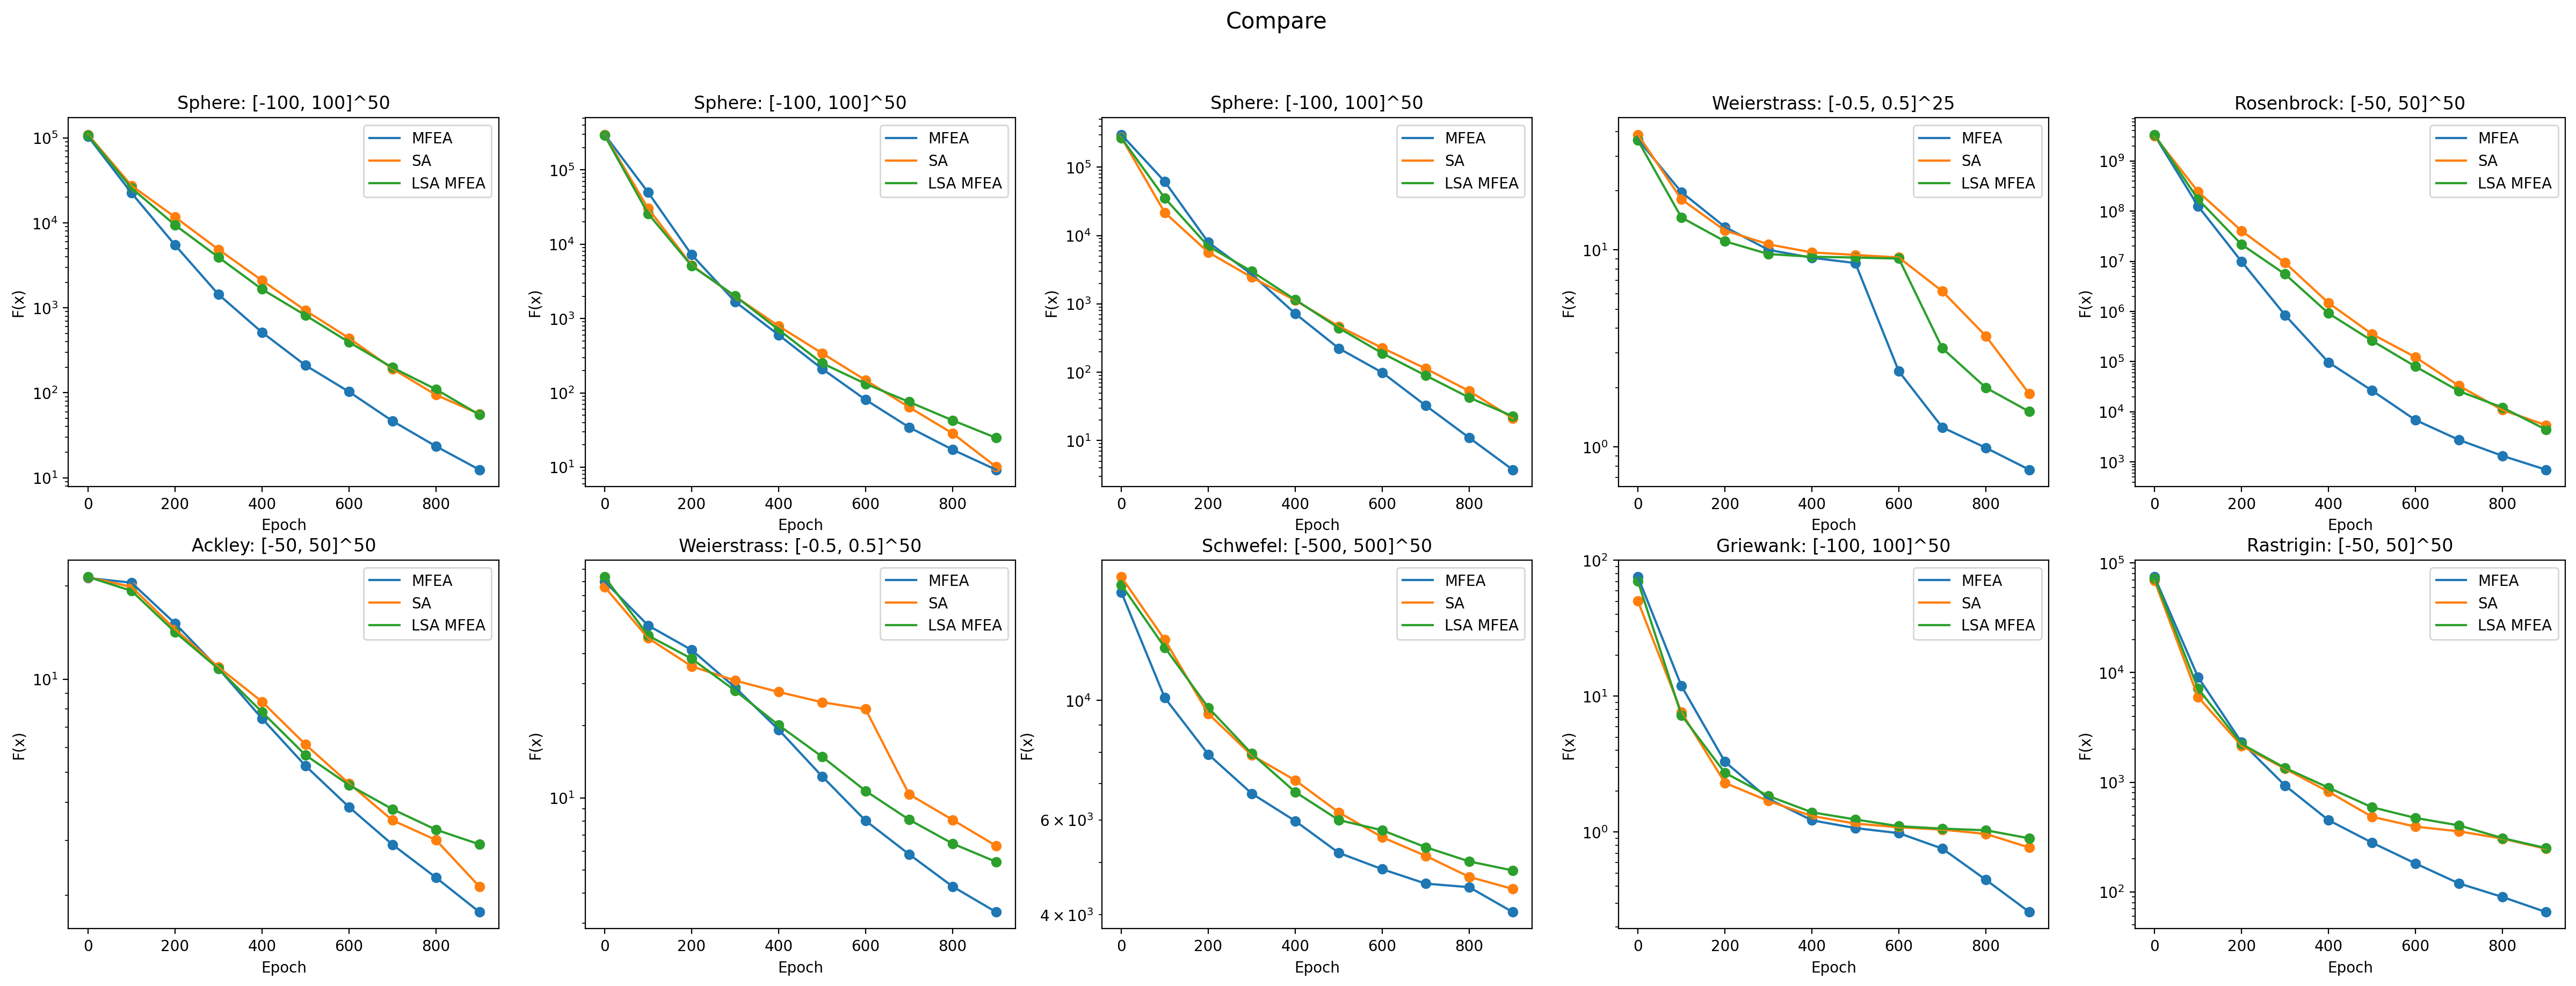

In [ ]:
fig = plt.figure(figsize = (30, 10), dpi= 200)
fig.suptitle("Compare\n", size = 15)
fig.set_facecolor("white")

label_legend = ["MFEA", "SA", "LSA MFEA"]

for i in range (len(cec17_10tasks)):
    for idx, sub_his in enumerate([mfea_his, sa_his, lsa_his]): 
        plt.subplot(2, int(len(cec17_10tasks) / 2), i + 1)

        plt.plot(np.arange(0, 1000, 100), sub_his[np.arange(0, 1000, 100), i], label= label_legend[idx])
        plt.scatter(np.arange(0, 1000, 100), sub_his[np.arange(0, 1000, 100), i])
        plt.legend()

    plt.title(cec17_10tasks[i].name)
    plt.xlabel("Epoch")
    plt.ylabel("F(x)")
    plt.yscale("log")

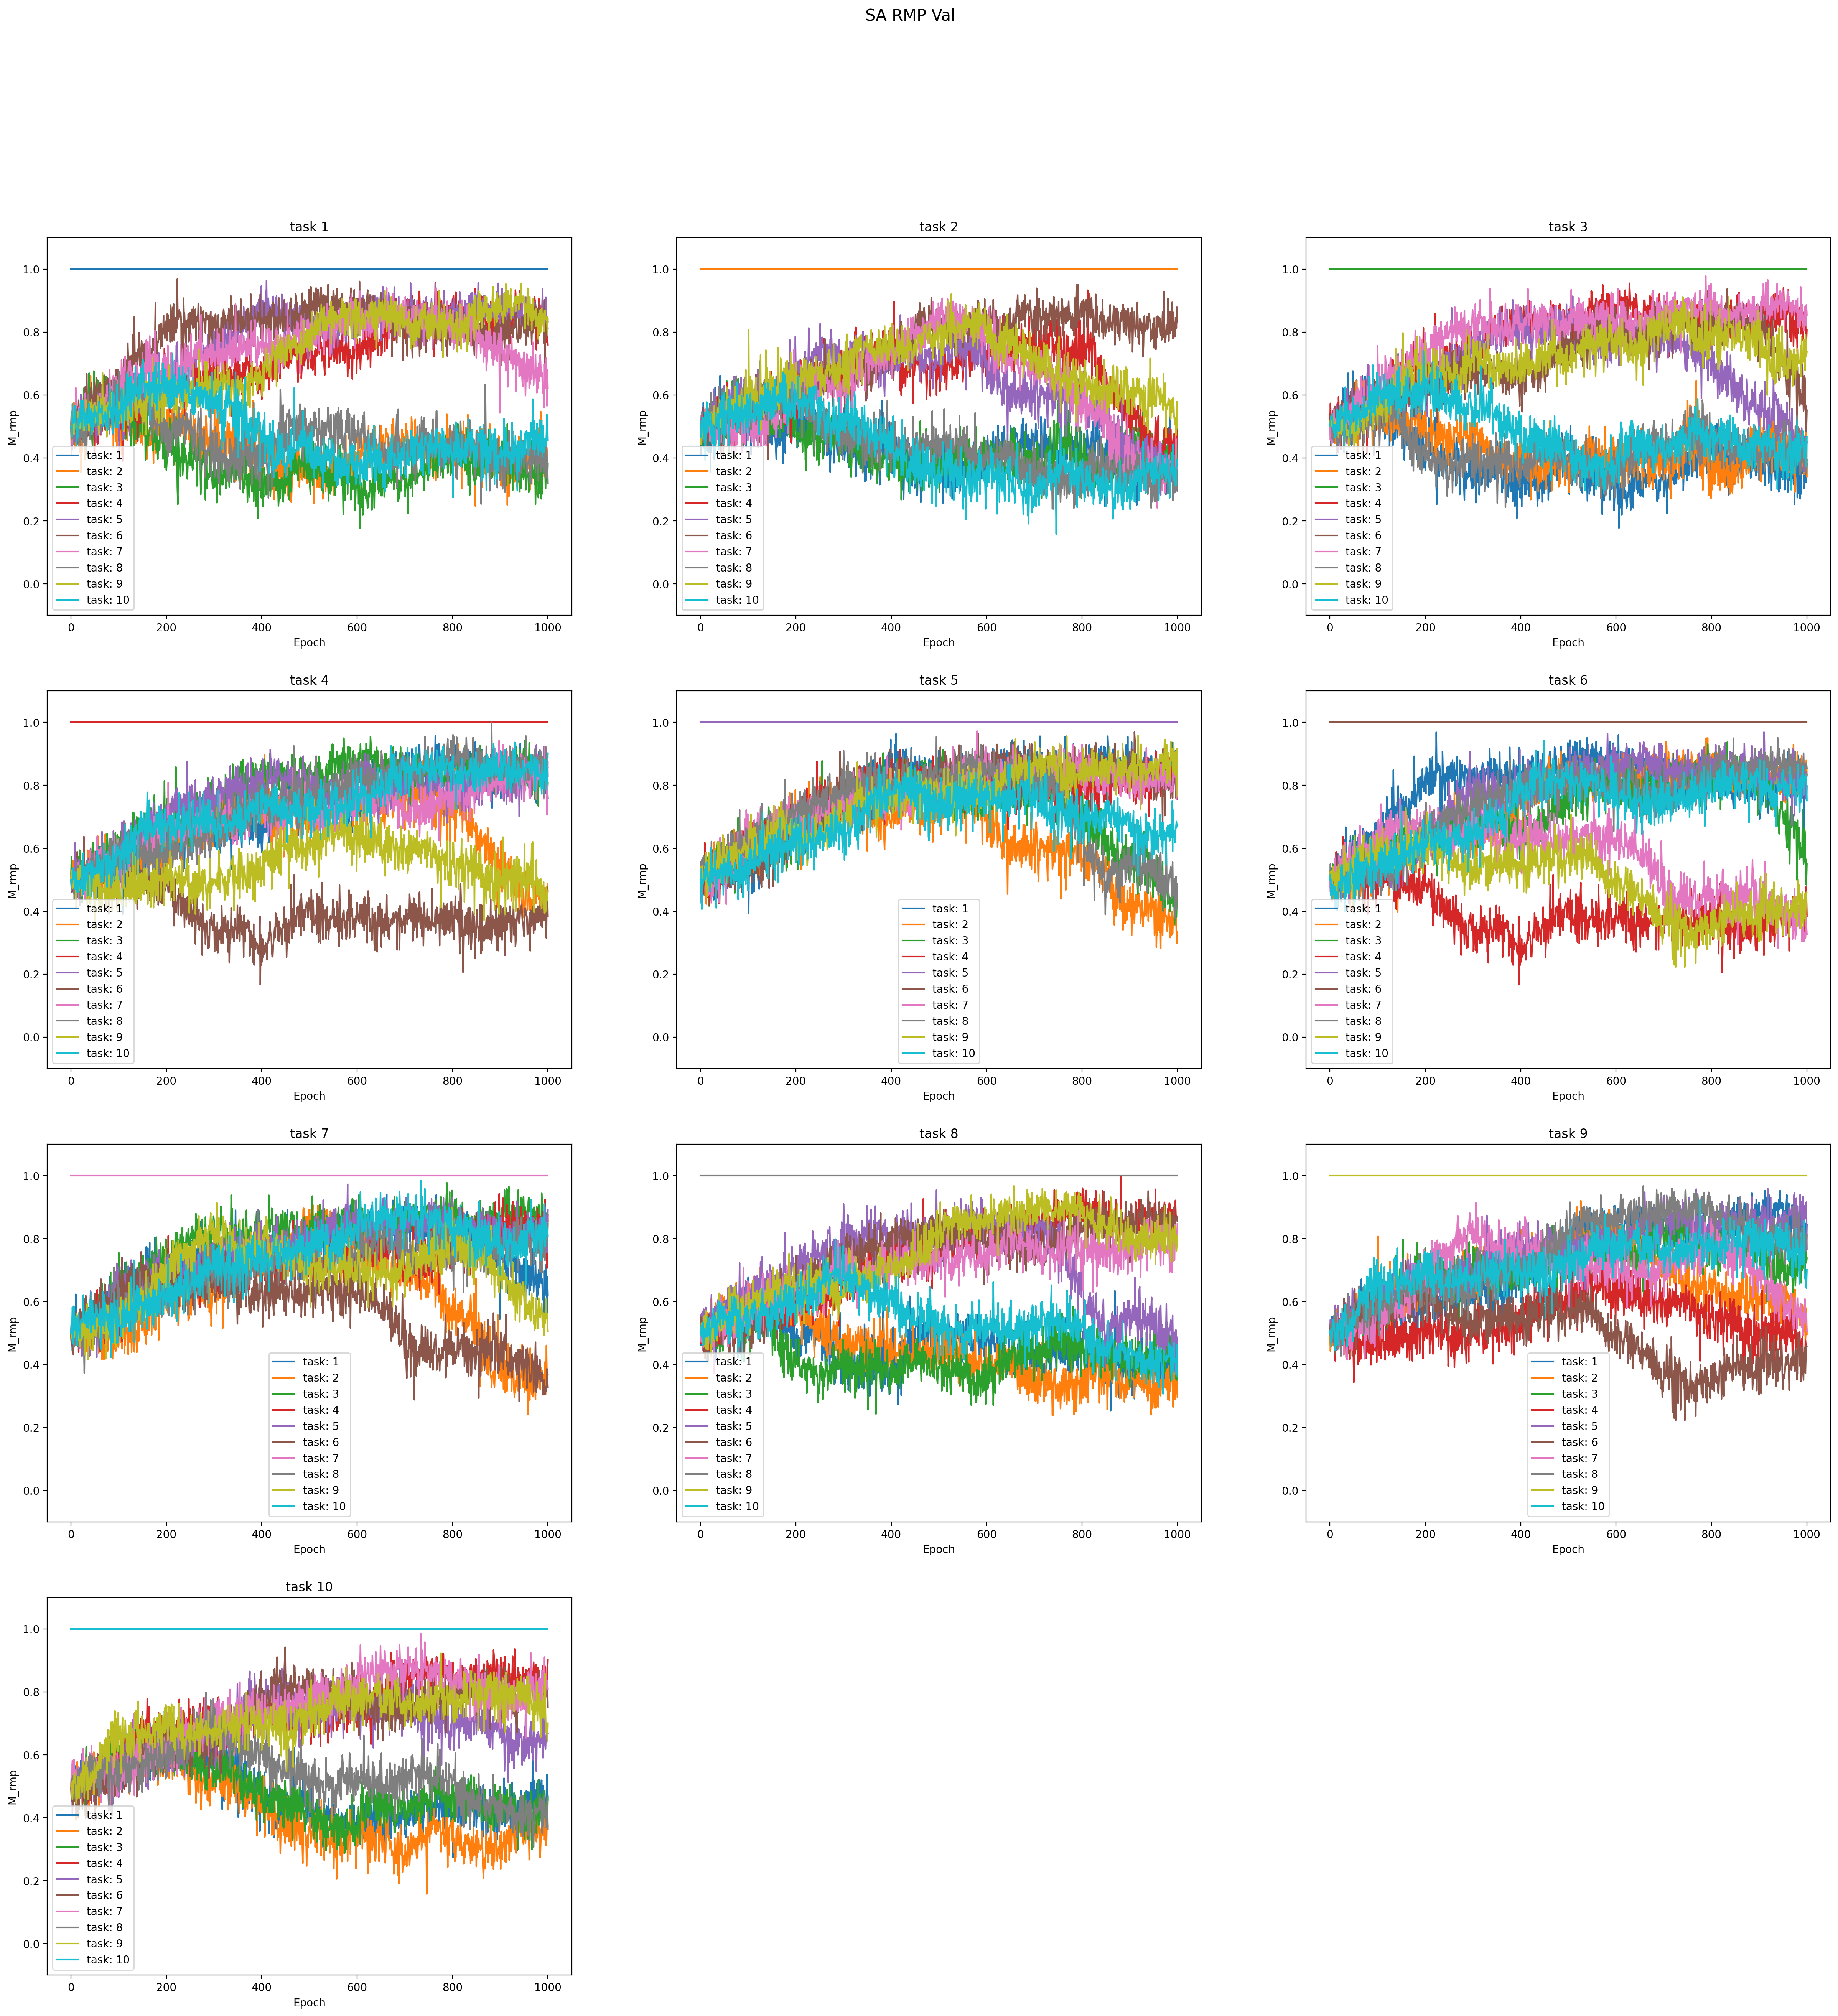

In [ ]:
fig = plt.figure(figsize = (30, 30), dpi= 200)
fig.suptitle("SA RMP Val\n", size = 15)
fig.set_facecolor("white")

for i in range (len(cec17_10tasks)):
    for j in range (len(cec17_10tasks)):
        r, c = min(i, j), max(i, j)
        if i != j: 
            plt.subplot(int(np.ceil(len(cec17_10tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(len(sa_rmp_his[r][c])), np.array(sa_rmp_his[r][c])[:, 0], label= 'task: ' +str(j + 1))
            plt.legend()
        else:
            plt.subplot(int(np.ceil(len(cec17_10tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(1000), np.ones_like(np.arange(1000)), label= 'task: ' +str(j + 1))
            plt.legend()




    plt.title('task ' + str( i + 1))
    plt.xlabel("Epoch")
    plt.ylabel("M_rmp")
    plt.ylim(bottom = -0.1, top = 1.1)


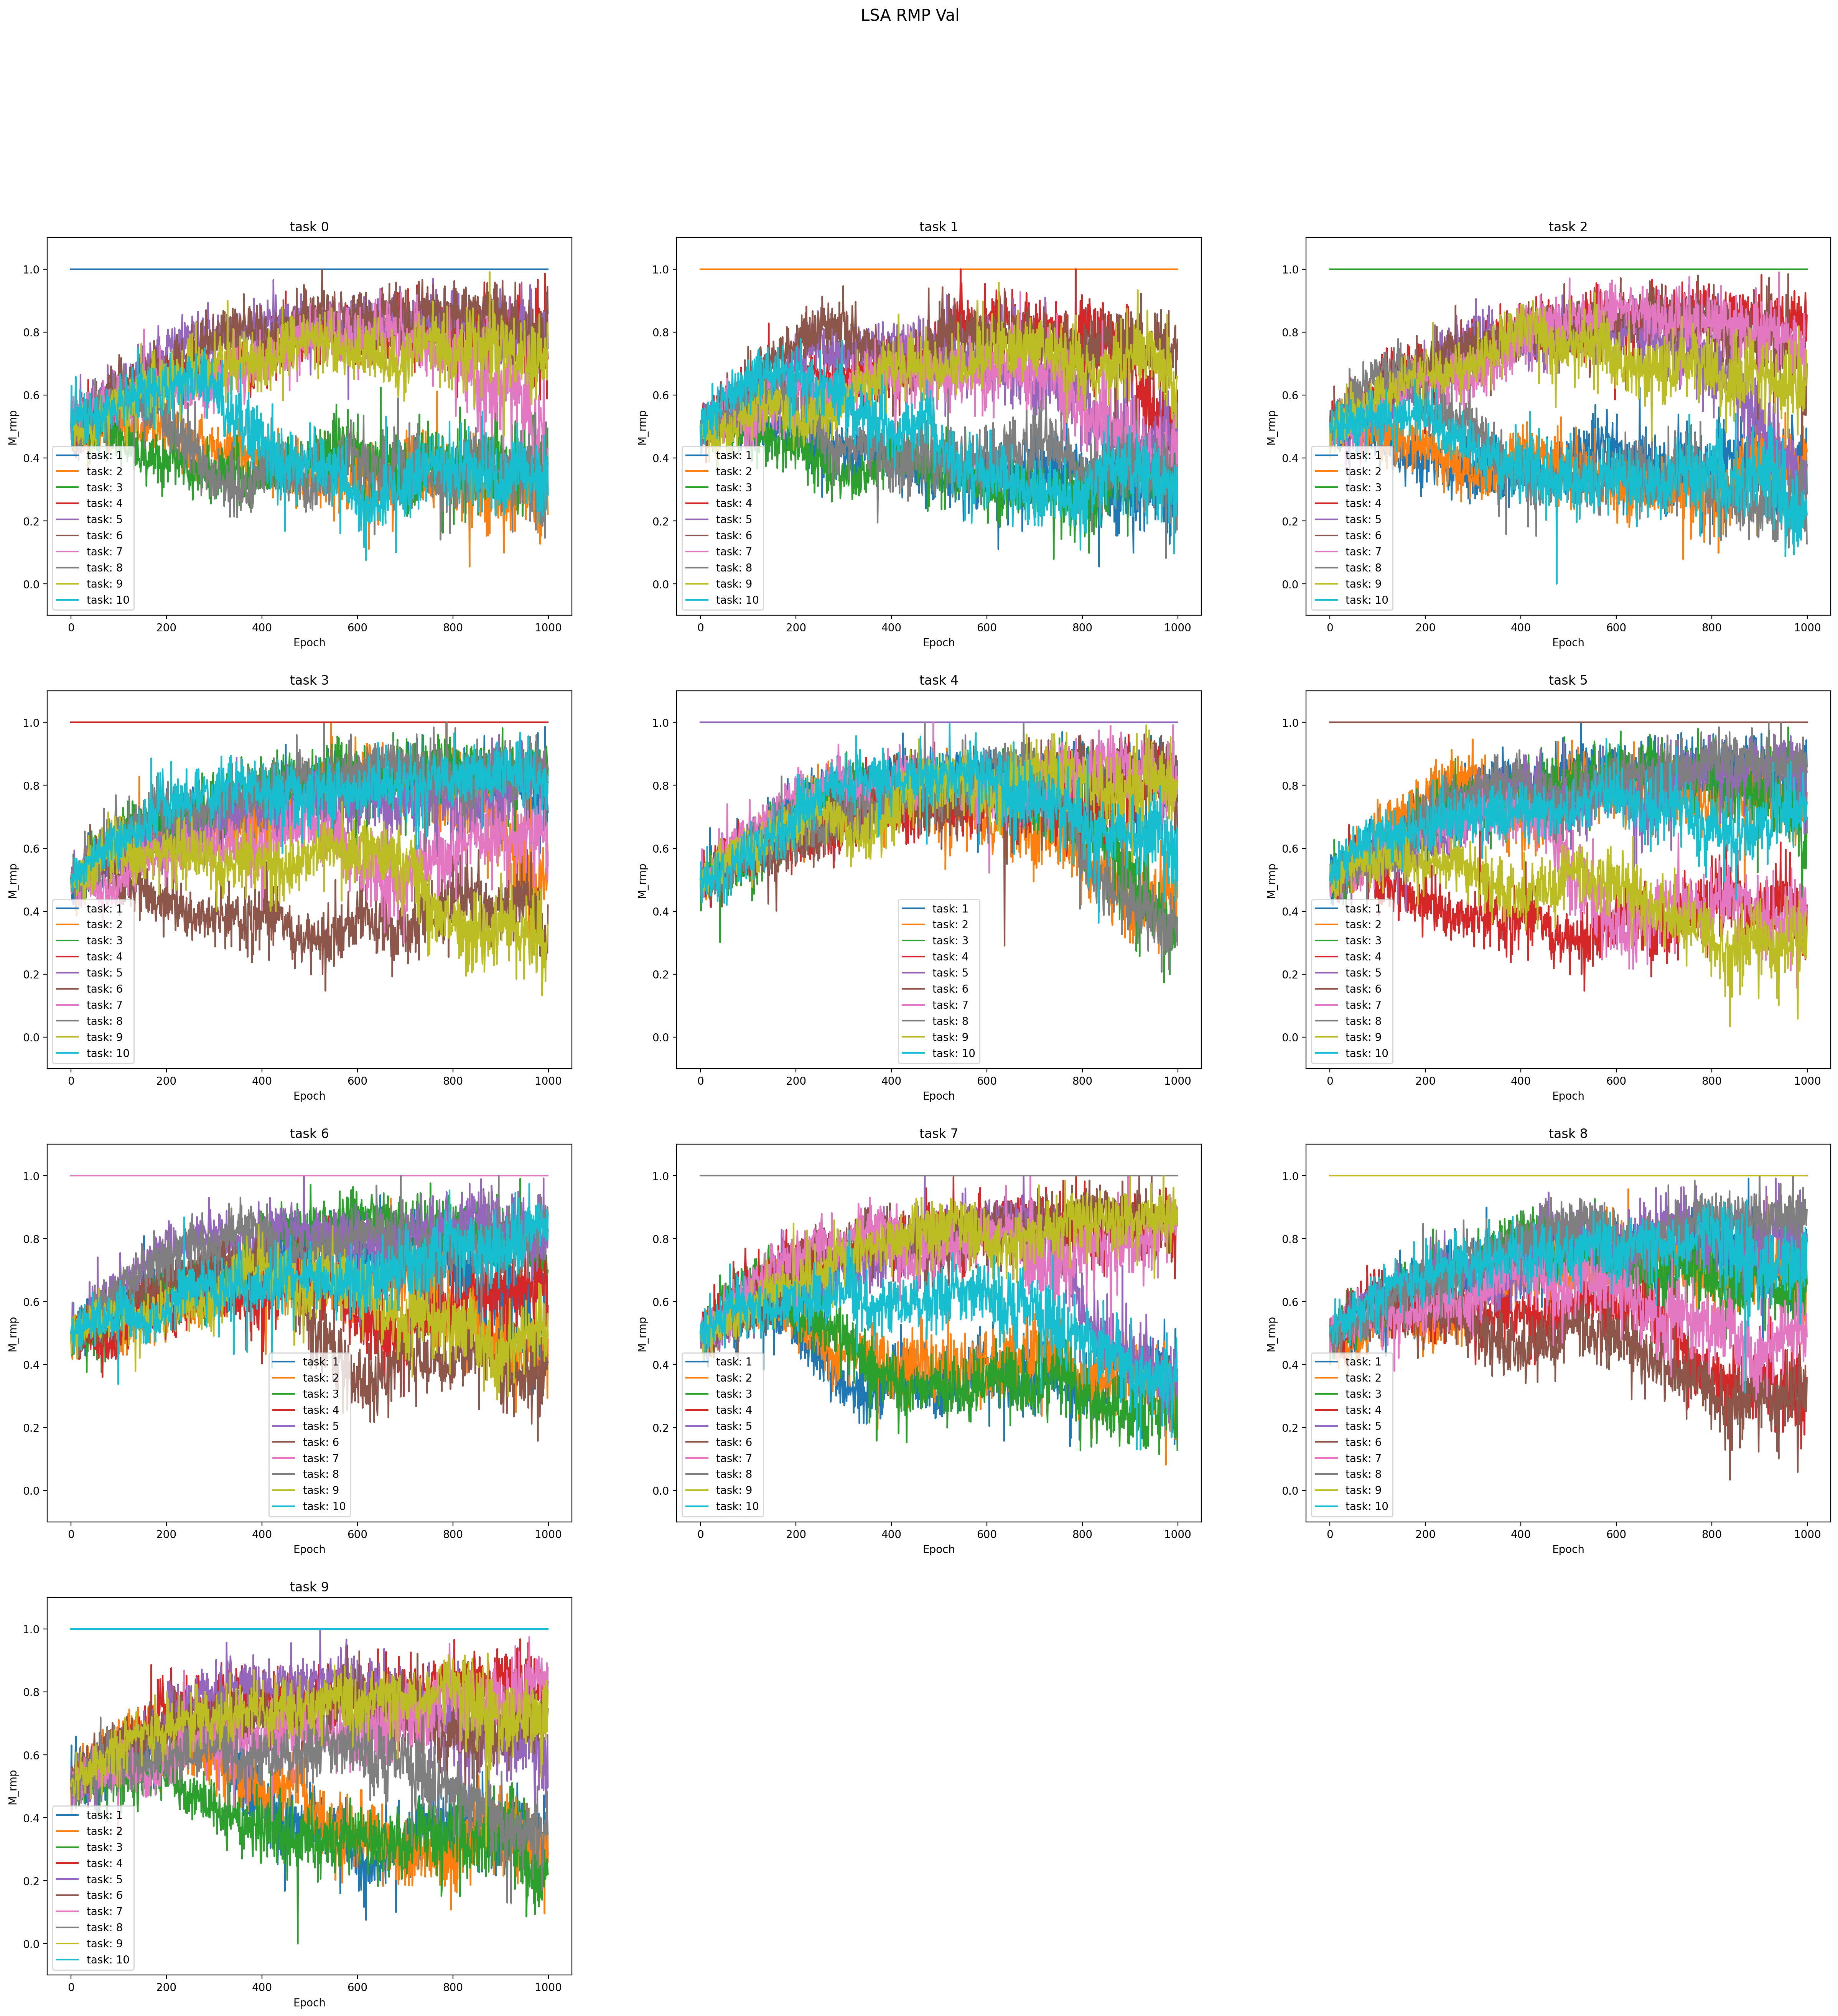

In [ ]:
fig = plt.figure(figsize = (30, 30), dpi= 200)
fig.suptitle("LSA RMP Val\n", size = 15)
fig.set_facecolor("white")

for i in range (len(cec17_10tasks)):
    for j in range (len(cec17_10tasks)):
        r, c = min(i, j), max(i, j)
        if i != j: 
            plt.subplot(int(np.ceil(len(cec17_10tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(1000), np.array(lsa_rmp_his[r][c])[:1000, 0], label= 'task: ' +str(j + 1))
            plt.legend()
        else:
            plt.subplot(int(np.ceil(len(cec17_10tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(1000), np.ones_like(np.arange(1000)), label= 'task: ' +str(j + 1))
            plt.legend()



    plt.title('task ' + str( i))
    plt.xlabel("Epoch")
    plt.ylabel("M_rmp")
    plt.ylim(bottom = -0.1, top = 1.1)



#### GECCO 20
